<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 3
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Support Vector Machine (SVM)

In [10]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
#import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

## Limpieza del dataset

In [11]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Se crea la columna que dice si se asignó la habitación pedida
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel",
    "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type",
    "deposit_type", "customer_type", "agent" ], drop_first=True)

hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)


## Encogimiento del dataset

Siendo que SVM es un método costoso, se decide probar utilizando un dataset de entrenamiento reducido. En caso que el rendimiento no sea tan diferente, se optimizarán los hiperparámetros utilizando este dataset reducido y luego se entrenará al modelo utilizando todo el split de train.

Además se decidió utilizar pocos folds para el cross validation para reducir el tiempo que se tardaba. El rendimiento fue demasiado afectado. 

In [12]:
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)
df_y = hotels_df_mod['is_canceled'].copy()

x_train_grande, x_test_grande, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.7, test_size=0.30, random_state=2)

In [13]:
svm_model = SVC(cache_size=1024, random_state = 2)

params_grid = {'kernel':['linear', 'rbf']}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train_grande,y_train)

y_pred = model.predict(x_test_grande)
score = f1_score(y_test, y_pred)
print("Parámetros:", model.best_params_, "\nF1 score: ", round(score, 3))

Parámetros: {'kernel': 'rbf'} 
F1 score:  0.833


In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.2, test_size=0.30, random_state=2)

svm_model = SVC(cache_size=1024, random_state = 2)

params_grid = {'kernel':['linear', 'rbf']}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Parámetros:", model.best_params_, "\nF1 score: ", round(score, 3))

Parámetros: {'kernel': 'rbf'} 
F1 score:  0.818


Siendo que el rendimiento al utilizar un dataset del doble de tamaño es solo 1% mejor, se considera que es buena idea trabajar con el dataset reducido.

## Optimización de hiperparámetros

Siendo que los distintos kernels utilizan distintos parámetros, no tiene sentido hacer una comparación todos contra todos porque habrá iteraciones que al fin y al cambo sean iguales, por lo que se realizará un grid search para cada kernel.

### Kernel: lineal

Hiperparámetros:

* C : es un parámetro de regularización, debe ser estrictamente positivo.

Dado que la fuerza de la regularización es inversamente proporcional a C
- un valor pequeño significa que el margen se calcula utilizando muchas o todas las observaciones alrededor de la línea de separación (más regularización).
- un valor grande significa que el margen se calcula sobre observaciones cercanas a la línea de separación (menos regularización).

In [15]:
svm_model = SVC(kernel='linear', cache_size=1024, random_state = 2)

params_grid = { 
                'C':[1, 5, 10, 50, 100, 500, 1000]
                }

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Kernel lineal, parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Kernel lineal, parámetros: {'C': 50} 
F1 score:  0.805


### Kernel: radial

Hiperparámetros:

* C : es un parámetro de regularización.

* gamma: define cuánta influencia tiene un solo ejemplo de entrenamiento. Cuanto mayor sea, más cerca deberán estar otros ejemplos para verse afectados  

La elección adecuada de C y gamma resulta fundamental para el rendimiento de la SVM. Es recomendable utilizar GridSearchCV con C y gamma espaciado exponencialmente para elegir buenos valores.

In [16]:
svm_model = SVC(kernel='rbf', cache_size=1024, random_state = 2)

params_grid = { 
                'C':[1, 5, 10, 50, 100, 500, 1000],
                'gamma':['scale', 'auto', 1, 5, 10, 50, 100, 500, 1000]
                }

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Kernel radial, parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Kernel radial, parámetros: {'C': 10, 'gamma': 'scale'} 
F1 score:  0.829


### Kernel: polinómico

Hiperparametros:

* C : Parámetro de regularización.

* degree: Grado de la función kernel polinomial ('poly'). Ignorado por todos los demás núcleos

* gamma: define cuánta influencia tiene un solo ejemplo de entrenamiento. Cuanto más grande es, más cerca deben estar otros ejemplos para verse afectados.

* coef0 : se corresponde con el parámetro r de la ecucacion del kernel
$K(a, b) =  (a \cdot b + r) ^ d$ ($d$ es el grado del polinomio).

La elección adecuada de C y gamma es fundamental para el rendimiento de la SVM. Se recomienda usar GridSearchCV con C y gamma espaciado exponencialmente para elegir buenos valores.

In [17]:
svm_model = SVC(kernel='poly', cache_size=1024, random_state = 2)

params_grid = { 
                'C': [10, 50, 100],
                'gamma': ['scale', 'auto', 1, 5],
                'degree': [1, 2, 3, 4],
                'coef0': [0, 1, 5]
                }

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Kernel polinómico, parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Kernel polinómico, parámetros: {'C': 50, 'coef0': 5, 'degree': 4, 'gamma': 'auto'} 
F1 score:  0.829


### Kernel: sigmoide

* C : Parámetro de regularización.

* degree: Grado de la función kernel polinomial ('poly'). Ignorado por todos los demás núcleos

* gamma: define cuánta influencia tiene un solo ejemplo de entrenamiento. Cuanto más grande es, más cerca deben estar otros ejemplos para verse afectados.

* coef0 : se corresponde con el parámetro r de la ecucacion del kernel
$K(a, b) =  (a \cdot b + r) ^ d$ ($d$ es el grado del polinomio).

In [18]:
svm_model = SVC(kernel='sigmoid', cache_size=1024, random_state = 2)

params_grid = { 
                'C': [10, 50, 100],
                'gamma': ['scale', 'auto', 1, 5],
                'degree': [1, 2, 3, 4],
                'coef0': [0, 1, 5, 10]
                }

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=-1
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Kernel sigmoide, parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Kernel sigmoide, parámetros: {'C': 100, 'coef0': 0, 'degree': 1, 'gamma': 'auto'} 
F1 score:  0.795


## Optimización de hiperparámetros del kernel radial

Siendo que la optimización de hiperparámetros para cada tipo de kernel es costosa, se optimizarán únicamente los del radial, que junto con el polinómico fueron los que devolvieron mejores resultados luego de esa optimización inicial. Esta elección se debe principalmente a la diferencia de tiempo de ejecución entre el polinómico y el radial, siendo el primero mucho más costoso.

In [19]:
svm_model = SVC(kernel='rbf', gamma='scale', cache_size=1024, random_state = 2)

params_grid = { 
                'C':list(range(5, 50, 1)),
                }

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=svm_model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      n_jobs=6
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Kernel radial, parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Kernel radial, parámetros: {'C': 9} 
F1 score:  0.83


## Entrenamiento del modelo con el dataset de train completo

Habiendo obtenido los mejores hiperparámetros para ese conjunto reducido, ahora se decide entrenar el modelo con el conjunto completo de train, utilizando los hiperparámetros obtenidos. Es cierto que hubiese sido mejor entrenar el modelo con el conjunto completo de train y luego optimizar los hiperparámetros, pero se decidió hacerlo de esta manera para reducir el tiempo de ejecución, siendo que por ejemplo, para el kernel polinómico, para cada combinación de hiperparámetros se tardaban 7 minutos.

In [21]:
x_train_grande, x_test_grande, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.7, test_size=0.30, random_state=2)

svm_model = SVC(kernel='rbf', gamma='scale', C=9, cache_size=1024, random_state = 2)

model = svm_model.fit(x_train_grande,y_train)

y_train_pred = model.predict(x_train_grande)
y_test_pred = model.predict(x_test_grande)

train_score = f1_score(y_train, y_train_pred)
test_score = f1_score(y_test, y_test_pred)

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

F1-Score sobre el set de entrenamiento: 0.883
F1-Score sobre el set de prueba: 0.842


## Predicción del test armado a partir de hotels_train

Matriz de confusión de los datos de prueba


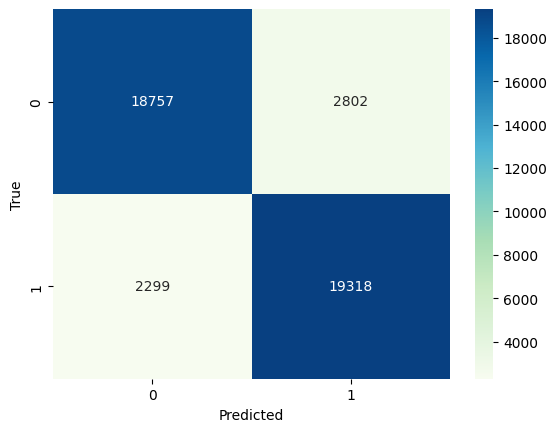

In [27]:
tabla=confusion_matrix(y_train, y_train_pred)
print("Matriz de confusión de los datos de prueba")
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

Matriz de confusión de los datos de prueba


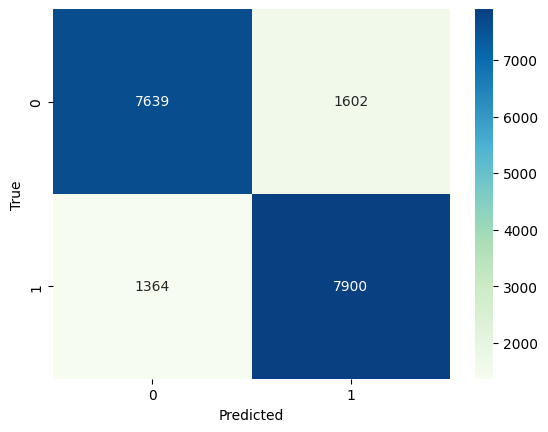

In [22]:
tabla=confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión de los datos de prueba")
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [23]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train,y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.882
Recall:  0.894
Precision:  0.873
F1 score:  0.883
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     21559
         1.0       0.87      0.89      0.88     21617

    accuracy                           0.88     43176
   macro avg       0.88      0.88      0.88     43176
weighted avg       0.88      0.88      0.88     43176



In [24]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test,y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test,y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.84
Recall:  0.853
Precision:  0.831
F1 score:  0.842
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      9241
         1.0       0.83      0.85      0.84      9264

    accuracy                           0.84     18505
   macro avg       0.84      0.84      0.84     18505
weighted avg       0.84      0.84      0.84     18505



## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [25]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)

id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns') #Esta es la columna que no debería estar en el dataset de test

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in test_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    test_df_mod[col] = scaler.fit_transform(test_df_mod[[col]])

#One-hot encoding para las columnas categóricas
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a predecir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [26]:
#Se realiza una predicción sobre test utilizando el modelo
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission.csv', index=False)